In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)
np.random.seed(324)

Pandas version:  1.3.4
Numpy version:  1.20.1
Scikit-learn version:  1.0


In [3]:
train_data = pd.read_csv("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/train_FD001.txt", sep = "\s+", header = None)
train_data.shape

(20631, 26)

In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
np.unique(train_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [6]:
# number of cycles for each model to fail
num_cycles_to_failure = train_data.groupby(0)[1].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [4]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength (total number of cycles for each engine) and early_rul as input and creates target rul.    
    Arguments:
        data_length: (scaler) Number of cycles for each engine
        early_rul: (scaler) Early RUL value to be set. When set to `None`, linear degradation
                   curve is used. (deafult: None)
    Returns:
        target_array: (1D float array) Target array
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        # This condition is needed when early rul is larger than data_length of an engine
        if early_rul_duration <= 0:    
            target_array = np.arange(data_length-1, -1, -1)
            return target_array
        else:
            target_array = np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return target_array

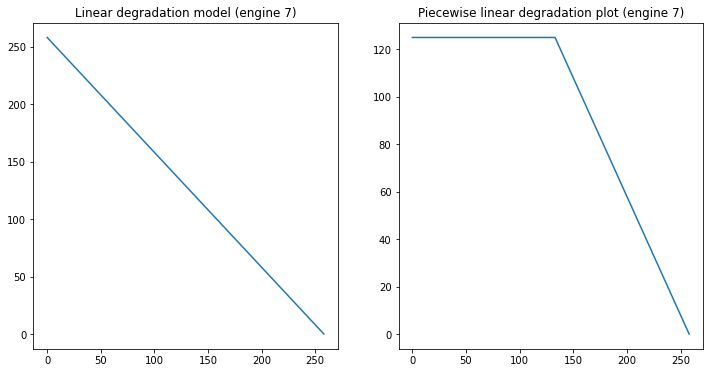

In [8]:
engine_7_linear_degradation_rul = process_targets(259, early_rul = None)
engine_7_piecewise_linear_degradation_rul = process_targets(259, early_rul = 125)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_7_linear_degradation_rul)
plt.title("Linear degradation model (engine 7)")
plt.subplot(122)
plt.plot(engine_7_piecewise_linear_degradation_rul)
plt.title("Piecewise linear degradation plot (engine 7)")
plt.show()

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, the goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

In [5]:
test_data = pd.read_csv("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/test_FD001.txt", sep = "\s+", header = None)
test_data.shape

(13096, 26)

In [10]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [12]:
np.unique(test_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [11]:
# cycle number for test data to start with
test_data.groupby(0)[1].count().values

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198])

In [6]:
# known test results 
true_rul = pd.read_csv('/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/RUL_FD001.txt', sep = '\s+', header = None)
#true_rul[0].values

First two columns of training data contain engine and cycle information respectively. So we don't need those columns while training an algorithm. Similarly columns 3-5 contain operational settings. We will also don't use those for training. It should be noted that some authors do use operational setting values to train their algorithm. But we will not do that. We will only use columns 6-26 values to train our algorithm as those are sensor measurements. But before we use those columns, we would first like to have some rough idea about the contents of the data. For that we will plot density plots of all sensor measurements of training data.

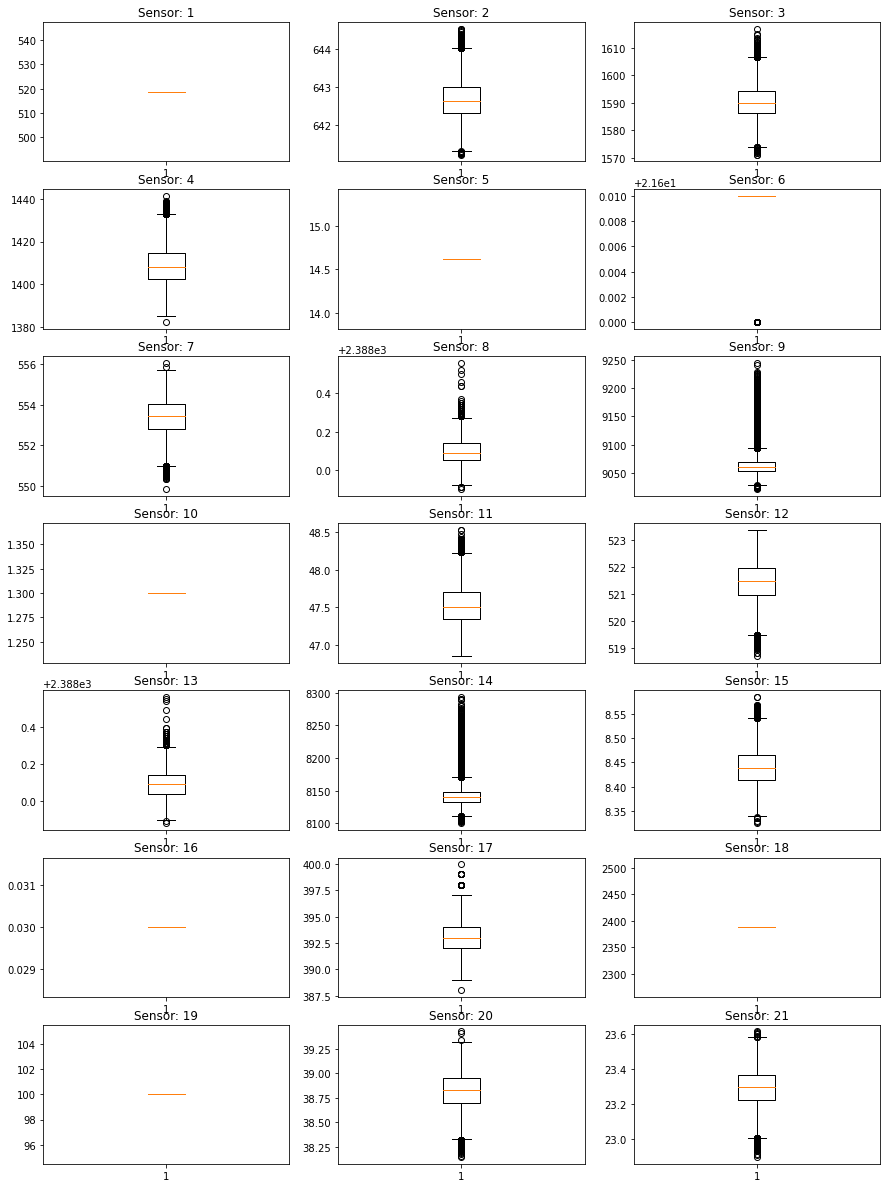

In [13]:
# box plots for sensor measurements (columns 5-25, total 21 columns)
plt.figure(figsize = (15, 21))
# column 5 in python means actual 6th column
for i in np.arange(5, 26):        
    temp = train_data.iloc[:, i]
    plt.subplot(7, 3, i-4)
    plt.boxplot(temp)
    plt.title("Sensor: "+ str(i-4))
plt.show()

From the above plot we see that columns 5, 9, 14, 20, 22, and 23 contain constant values. It also appears that Column 10 also contains only a few different values. We will check that. Constant values don't help us much while training an algorithm. Sometimes we also have to normalize data (subtract mean and divide by standard deviation). If a column contains a constant value, its standard deviation is zero. So normalization of that column is not possible as it requires division by zero. For these reasons, we will drop the columns containing constant values.

In [20]:
train_data[10].value_counts()

21.61    20225
21.60      406
Name: 10, dtype: int64

initial training data have a shape of 20631 by 26. We won't use engine info and operational settings for training. So after removing first 5 columns, our training data have a shape of 20631 by 21. From our previous data plotting, we found that 7 columns contain constant values. So ater removing those columns, our data have a shape of 20631 by 14. We choose to apply scaling individually to every engine.

In [7]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """
    Depending on values of window_length and shift, this function generates batchs of data and targets 
    from `input_data` and `target_data`. `target_data` is optional. If no `target_data` is given, i.e., 
    `target_data = None`, no `output_targets` are generated. The following formula is used to determine
    number of batches:     
        Number of batches = int(np.floor((len(input_data) - window_length)/shift)) + 1    
    **We don't check input dimensions using exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**    
    Arguments:
        input_data: (Must be 2D array) input data to function 
        target_data (optional): (Must be 1D array) Input rul values (default: None)
        window_length: (scalar) window length of data (default: 1)
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches (default: 1)        
    Returns:
        output_data: (2D float array) Output data that would be passed to machine learning model
        output_targets (optional): (1D float array) Output targets. Only generated if `target_data` is
                                   passed as argument.
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features) \
                    .reshape(num_batches, window_length, num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

For each engine in the test set, we need to predict one RUL value. To predict one RUL value, we need one example of test data for each engine. So the obvious choice is to use the last example of test data for each engine. If an example consists of a window of data, for a given window length, we will take the last window of data that can be extracted from test set for a particular engine. For example, assume that for a particular engine, test set data has a shape of 45 by 14. For window_length = 30, and shift = 1, we can extract 16 windowed datasets of size 30 by 14. But we have to predict only one number as RUL for that engine. So, out of the 16 datasets of size , we will use the last one for predicting RUL. This approach, though technically correct, is prone to mistakes. What happens if the measurements of last example have some outliers? In that case our prediction would be way off. One approach to circumvent this issue is to take, say, last 5 examples instead of only the last example for each engine. Then we will get 5 RUL prediction values. We can average those to come up with our final estimate of RUL. In this way our RUL estimate will be a little conservative but robust against outliers in the last test example.

In [8]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions. Finally it takes num_test_windows as
    the last input. num_test_windows sets how many examples we want from test data (from last).
    By default it extracts only the last example. The function returns last examples and number
    of last examples (a scaler) as output. We need the second output later. If we are extracting
    more than 1 last examples, we have to average their prediction results. The second scaler helps us do just that.
    Arguments:
        test_data_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)
    Returns:
        batched_test_data_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`. 
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

In [9]:
window_length = 1
shift = 1
early_rul = 125             # Set to None for linear degradation model
processed_train_data = []
processed_train_targets = []
# How many test examples to take for each engine. If set to 1 (this is the default), only last example of test data for 
# each engine are taken. If set to a different number, that many examples from last are taken. 
# Final output for an engine will be the average of output of all examples for that engine.
num_test_windows = 5   # Number of examples. Choose a different number to select that many test examples for each engine.
processed_test_data = []
num_test_windows_list = []  # This list keeps track of number of examples for all engines in the test set.
columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
train_data_first_column = train_data[0]
test_data_first_column = test_data[0]
# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns=columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns=columns_to_be_dropped))
train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])
num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())
# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul.shape)

(20631, 1, 14)
(20631,)
(500, 1, 14)
(100,)


In [10]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

Processed train data shape:  (20631, 14)
Processed test data shape:  (500, 14)


We will first find best set of parameters using grid search and then use those parameters to make predictions. In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 SVR models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter. Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [13]:
parameters = {"C":[1, 10, 50, 100],
             'epsilon':[1, 5, 10, 50],
             'kernel':["rbf"]}
tuned_svm_reg = GridSearchCV(SVR(),parameters,n_jobs = -1, cv= 10)
tuned_svm_reg.fit(processed_train_data, processed_train_targets)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100], 'epsilon': [1, 5, 10, 50],
                         'kernel': ['rbf']})

In [14]:
tuned_svm_reg.best_params_

{'C': 10, 'epsilon': 10, 'kernel': 'rbf'}

In [15]:
best_reg_model = tuned_svm_reg.best_estimator_
best_reg_model

SVR(C=10, epsilon=10)

In [16]:
# use the best model to predict the test set
rul_pred_tuned = best_reg_model.predict(processed_test_data)
preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
MAE_tuned = mean_absolute_error(true_rul, mean_pred_for_each_engine_tuned)
print("RMSE after hyperparameter tuning: ", RMSE_tuned)
print("MAE after hyperparameter tuning: ", MAE_tuned)

RMSE after hyperparameter tuning:  19.738175034113084
MAE after hyperparameter tuning:  14.78349837258218


Note that while prediction, we are predicting RUL values for last 5 examples of every engine. Then we take mean of all 5 predictions for each engine and calculate final RMSE. If instead we wish to take only the last example of every engine to make predictions and calculate RUL, we can do so by taking the last prediction of every engine as calculated before and calculate RMSE as follows.

In [17]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last example): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last example):  18.277687523158672
MAE (Taking only last example):  13.223495737105722


If you are not convinced by above calculations, for the sake of clarity, we will do the same thing in a more conventional way. First, we will extract last examples from each engine. Then we will make predictions using that data and compute new RMSE value. Finally, we will compare predicted rul of conventional method to that obtained before. We will do this only for this example as a demonstration. For other notebooks, we will just use results as obtained above.

In [20]:
window_length = 1
shift = 1
num_test_windows = 1    
processed_test_data_new = []
num_test_windows_list_new = []
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns=[0]).values    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")        
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)    
    processed_test_data_new.append(test_data_for_an_engine)
    num_test_windows_list_new.append(num_windows)
processed_test_data_new = np.concatenate(processed_test_data_new)
print("Processed test data shape: ", processed_test_data_new.shape)
print("True RUL shape: ", true_rul.shape)

Processed test data shape:  (100, 1, 14)
True RUL shape:  (100,)


In [21]:
processed_test_data_new = processed_test_data_new.reshape(-1, processed_test_data_new.shape[2])
print("New processed test data shape: ", processed_test_data_new.shape)

New processed test data shape:  (100, 14)


Now we will predict using new processed test data.

In [23]:
rul_pred_new = best_reg_model.predict(processed_test_data_new)
RMSE_new = np.sqrt(mean_squared_error(true_rul, rul_pred_new))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  18.277687523158672


Now compare rul_pred_new with previous prediction result: predicts_for_last_example. We can check and see they are identical.

In [24]:
(rul_pred_new == preds_for_last_example).all() == True

True

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. We can compute the S-metric as follows.

In [25]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  1004.7447548557302


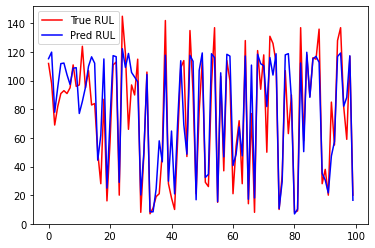

In [26]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "blue")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "red")
plt.legend()
plt.show()